# *RECONSTRUCTION SKILL EVALUATION*

The Analog Method (AM) is a statistical downscaling method very well suited for reconstruction of climatic time series. The reconstruction can reproduce the climatic characteristics of the local phenomena a certain region, based on the relationship between the large scale and the observed local weather patterns.

To validate the quality of the reconstructions is the important to look how the climatic characteristics are reproduced.

This notebook is an example of a fairly complete skill evaluation of the reconstructions and a comparision with the skill of the reanalysis. It contains the following elements:

- Time series skill (Bias, Heidke Skill Score, SSMSE and Taylor diagrams) for daily, monthly and yearly series
- Seasonality
- Equality of distributions
- Daily indices (Days above zero degree, days of precipitation above threshold)

In [1]:
import re
import os
import cfgrib
import datetime
import itertools
import rascal.utils
import rascal.analogs
import rascal.indices
import rascal.analysis

import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from scipy.stats import percentileofscore

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
initial_year = 1900
final_year = 2010

station_to_validate = "segovia"
variable_to_validate = "PCP"

if variable_to_validate == "PCP":
    best_method = {
        "avila": "quantilemap020",
        "colmenar": "quantilemap100",
        "navacerrada": "closest",
        "retiro": "closest",
        "segovia": "average10"
    }
elif variable_to_validate == "TMAX":
    best_method = {
        "avila": "quantilemap020",
        "colmenar": "quantilemap100",
        "navacerrada": "quantilemap100",
        "retiro": "quantilemap100",
        "segovia": "quantilemap020"
    }
elif variable_to_validate == "TMIN":
    best_method = {
        "avila": "quantilemap100",
        "colmenar": "quantilemap100",
        "navacerrada": "quantilemap050",
        "retiro": "quantilemap020",
        "segovia": "quantilemap050"
    }
    
if variable_to_validate == "PCP":
    threshold=1
    inverse=False
elif variable_to_validate in ["TMAX", "TMIN"]:
    threshold=0
    inverse=True

In [3]:
# How to group the data when resampling the daily data to monthly or yearly
groupings = {
    "TMAX": "mean",
    "TMIN": "mean",
    "PCP": "sum"
}

reanalysis_variables = {
    "TMAX": ["SURF_167"],
    "TMIN": ["SURF_167"],
    "PCP": ["SURF_228"]
}

# How to group the data to daily resolution
reanalysis_grouping = {
    "TMAX": "1D_max",
    "TMIN": "1D_min",
    "PCP": "1D_sum"
}

units = {
    "TMAX": "[$^\circ$C]",
    "TMIN": "[$^\circ$C]",
    "PCP": "[mm]"
}

if variable_to_validate == "PCP":
    hydroyear=True
else: 
    hydroyear=False
    
ensemble_variables = ["PCP"]

### Paths

In [4]:
if variable_to_validate == "PCP":
    predictor = "SURF_71.162andSURF_72.162-SURF_71.162andSURF_72.162-1"
elif variable_to_validate in ["TMAX", "TMIN", "TMEAN"]:
    predictor = "925_129-SURF_167-1"
    
observations_directory = "./data/observations/"
reanalysis_directory = "./data/reanalysis/"
reconstructions_directory = "/".join([".", "output", variable_to_validate, predictor]) + "/"

# 0) LOAD DATA 

To evaluate the skill of the reconstructions the following data is needed:
- Observational data: To compare the reconstructions with the original data.
- Reconstructions: All the different reconstructions for the same variable in the same time, to compare how different methods perform in different tasks.
- Reanalysis data: To compare the added value of using RASCAL instead of using only the reanalysis.

## 0.1) STATION DATA

In [5]:
station = rascal.utils.Station(path= observations_directory + station_to_validate + '/')
station_daily = station.get_data(variable=variable_to_validate, skipna=False)
station_daily.index.name = "time"

## 0.2) REANALYSIS DATA

Load the reanalysis or reference model data. If the variable is part of an ensemble, all the members of the ensemble are loaded in a single dataframe as "'variable name'_'member number'". Once the data is extracted in the gridpoint of the station, a .csv file is saved, to save computation time in future runs.

In [6]:
reanalysis_data_name = "_".join([station.name, variable_to_validate, "ERA20C.csv"])
reanalysis_series_filepath = "/".join([reanalysis_directory, "series", reanalysis_data_name])
reanalysis_original_path = "/".join([reanalysis_directory, "ERA20C/"])

# Load the .csv file if it already exists
if os.path.exists(reanalysis_series_filepath):
    reanalysis_data = pd.read_csv(reanalysis_series_filepath, index_col=0)
    reanalysis_data.index = pd.to_datetime(reanalysis_data.index)
    reanalysis_data.index.name = "time"
    
# If it does not, extract the data in the gridpoint from the original files
else:
    if variable_to_validate in ensemble_variables:
        reanalysis_data = []
        for ensemble_member in range(reanalysis_ensemble_members):
            ensemble_member_data = rascal.analysis.get_reanalysis_in_gridpoint(
                reanalysis_original_path,
                initial_year=initial_year,
                final_year=final_year,
                variable=reanalysis_variables[variable_to_validate],
                grid_point={"lat": station.latitude, "lon": station.longitude},
                file_format=".grib",
                grouping=reanalysis_grouping[variable_to_validate],
                ensemble_member=ensemble_member    
            )
            reanalysis_data.append(ensemble_member_data)
        reanalysis_data = pd.concat(reanalysis_data, axis=1)
        
    else:
        reanalysis_data = get_reanalysis_in_gridpoint(
            reanalysis_original_path,
            initial_year=initial_year,
            final_year=final_year,
            variable=reanalysis_variables[variable_to_validate],
            grid_point={"lat": station.latitude, "lon": station.longitude},
            file_format=".grib",
            grouping=reanalysis_grouping[variable_to_validate],
            ensemble_member=None 
        )
        
    reanalysis_data.to_csv(reanalysis_data_name)


In [7]:
reanalysis_daily = rascal.analysis.get_reanalysis_ensemble(
    reanalysis_data, 
    variable_to_validate=variable_to_validate,
    freq="1D", 
    grouping=groupings[variable_to_validate]
)

## 0.3) RECONSTRUCTIONS DATA

In [8]:
reconstructions_daily = rascal.analysis.get_reconstruction_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1D',
    grouping=groupings[variable_to_validate]
)

## 0.4) DAILY, MONTHLY AND YEARLY FREQUENCY

In [9]:
# Daily data 
rskill = rascal.analysis.RSkill(
    observations=station_daily,
    reconstructions=reconstructions_daily,
    reanalysis=reanalysis_daily
)

# Monthly data
rskill_1m = rskill.resample(freq="1m", grouping=groupings[variable_to_validate], hydroyear=hydroyear, skipna=False)

# Yearly data
rskill_1y = rskill.resample(freq="1Y", grouping=groupings[variable_to_validate], hydroyear=hydroyear, skipna=False)

# 1) TIME SERIES

## 1.1) Daily time series

In [10]:
initial_date = datetime.datetime(1900, 1, 1)
final_date = datetime.datetime(2010, 1, 1)

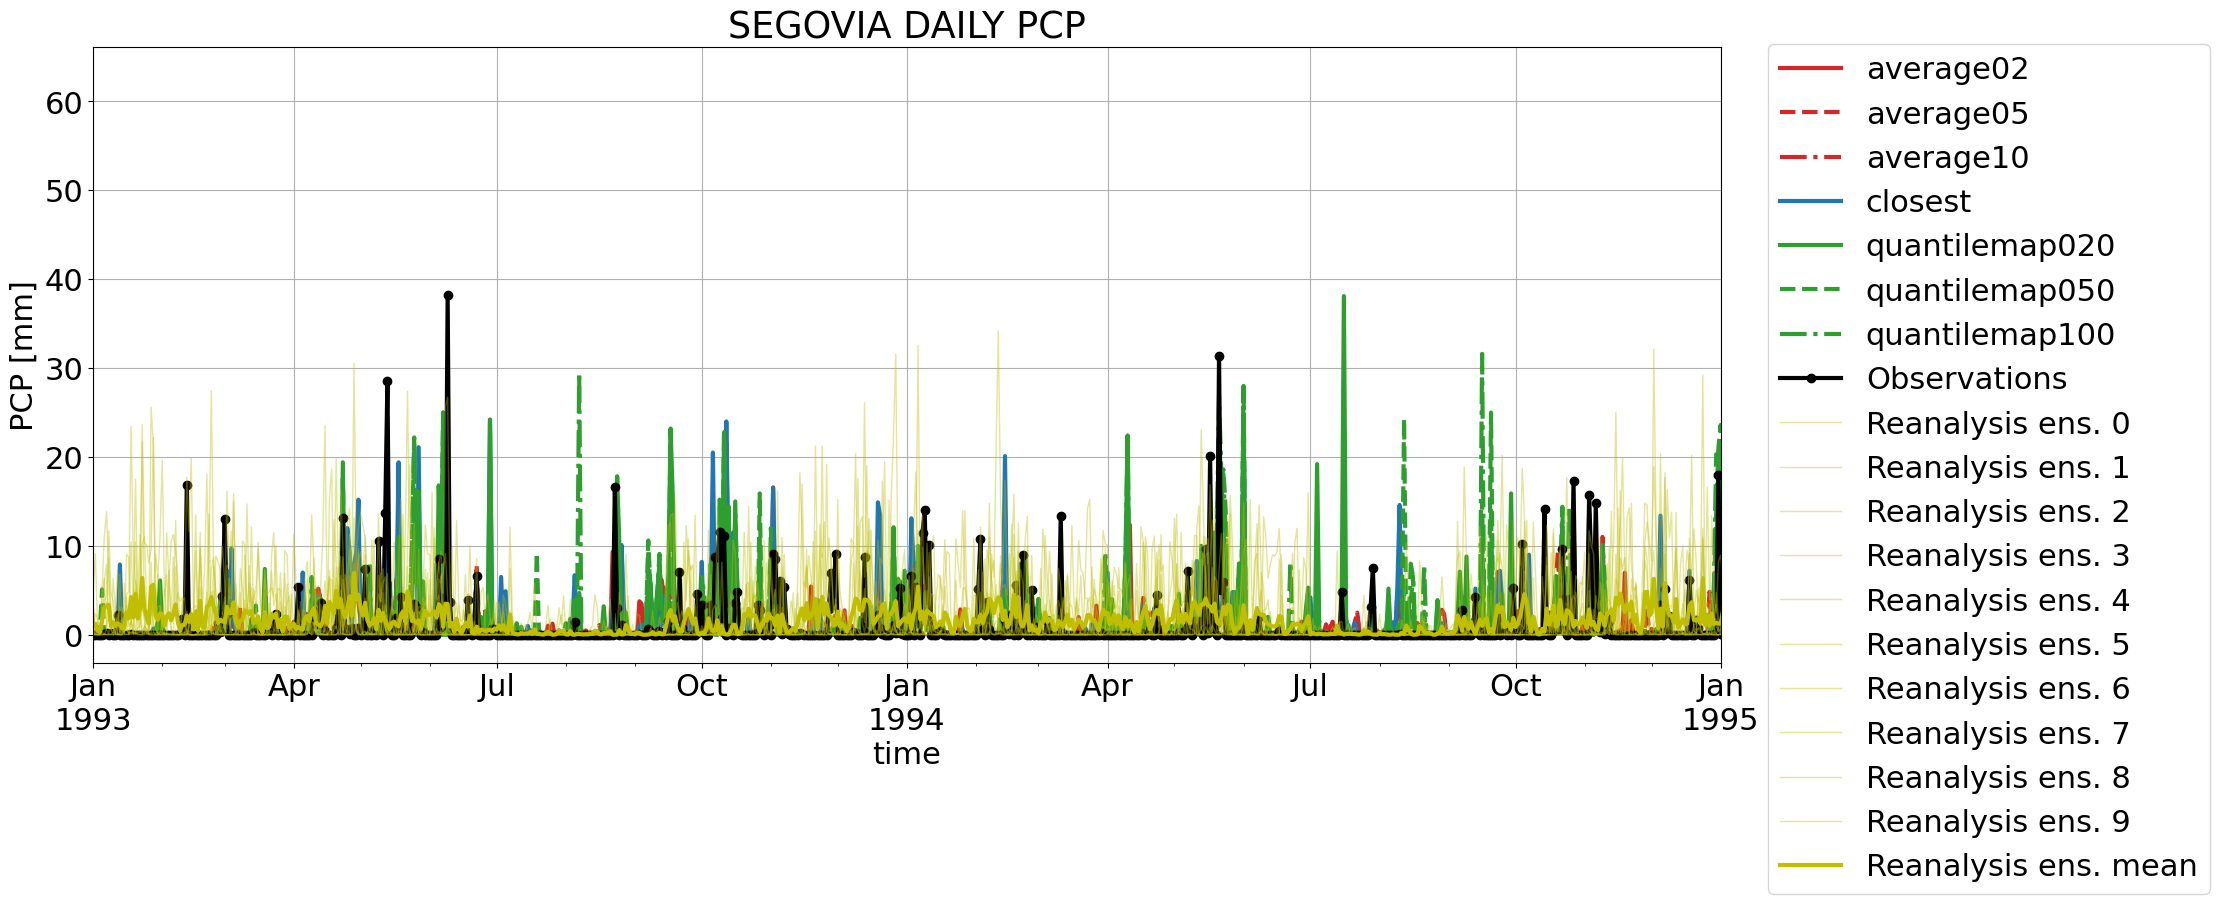

In [11]:
fig, ax = rskill.plotseries(start=datetime.datetime(1993, 1, 1), end=datetime.datetime(1995, 1, 1))
# fig, ax = rskill.plotseries(start=initial_date, end=final_date)
ax.set_title(station.name.upper() + " DAILY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.show()

## 1.2) Daily skill table

In [12]:
_, daily_skill = rskill.skill(threshold=1)

In [13]:
daily_skill

bias      rmse        r2       std  \
PCP_average02_reconstructions       0.022201  4.052562  0.187429  2.767181   
PCP_average05_reconstructions       0.020885  3.660745  0.243739  2.150073   
PCP_average10_reconstructions       0.021572    3.4999  0.281626   1.84095   
PCP_closest_reconstructions         0.017257  4.603922  0.149194  3.524461   
PCP_quantilemap020_reconstructions -0.139883   4.32505   0.24982   3.41147   
PCP_quantilemap050_reconstructions -0.111823  4.275361  0.272258  3.371581   
PCP_quantilemap100_reconstructions -0.091289  4.234589  0.279937  3.323541   
PCP_0_reanalysis                   -0.244916  4.813459  0.009343  3.191954   
PCP_1_reanalysis                   -0.159839  4.702097  0.019212  3.125931   
PCP_2_reanalysis                   -0.115485  4.644256  0.013779  3.053697   
PCP_3_reanalysis                   -0.113325  4.674426  0.020866  3.163191   
PCP_4_reanalysis                   -0.176451  4.708204  0.021741  3.144951   
PCP_5_reanalysis                   -0.122635  4.689544  0.012508  3.108777   
PCP_6_reanalysis                   -0.139635  4.708883  0.022282  3.152829   
PCP_7_reanalysis                   -0.189647  4.757475  0.014372  3.289381   
PCP_8_reanalysis                   -0.136502  4.704977  0.021497  3.153144   
PCP_9_reanalysis                   -0.155743  4.713946  0.020526  3.153393   
PCP_mean_reanalysis                -0.155418  3.690095  0.046535  1.186987   

                                          bs  
PCP_average02_reconstructions       0.262928  
PCP_average05_reconstructions       0.284632  
PCP_average10_reconstructions       0.291333  
PCP_closest_reconstructions         0.248507  
PCP_quantilemap020_reconstructions  0.251032  
PCP_quantilemap050_reconstructions  0.237630  
PCP_quantilemap100_reconstructions  0.229085  
PCP_0_reanalysis                    0.357805  
PCP_1_reanalysis                    0.355329  
PCP_2_reanalysis                    0.353581  
PCP_3_reanalysis                    0.348143  
PCP_4_reanalysis                    0.358242  
PCP_5_reanalysis                    0.347949  
PCP_6_reanalysis                    0.347123  
PCP_7_reanalysis                    0.354504  
PCP_8_reanalysis                    0.347609  
PCP_9_reanalysis                    0.348725  
PCP_mean_reanalysis                 0.505608

## 1.3) Daily Taylor diagram

(<Figure size 500x500 with 1 Axes>,
 <rascal.analysis.TaylorDiagram at 0x7f90c02759a0>)

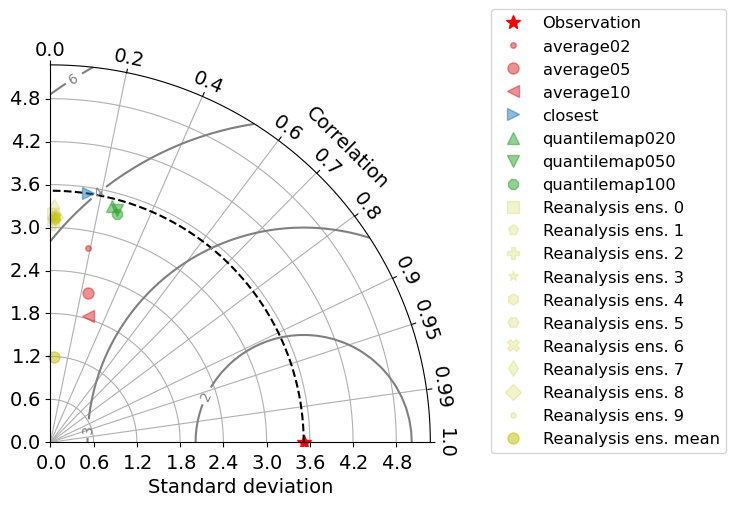

In [14]:
rskill.taylor()

## 1.4) Monthly time series

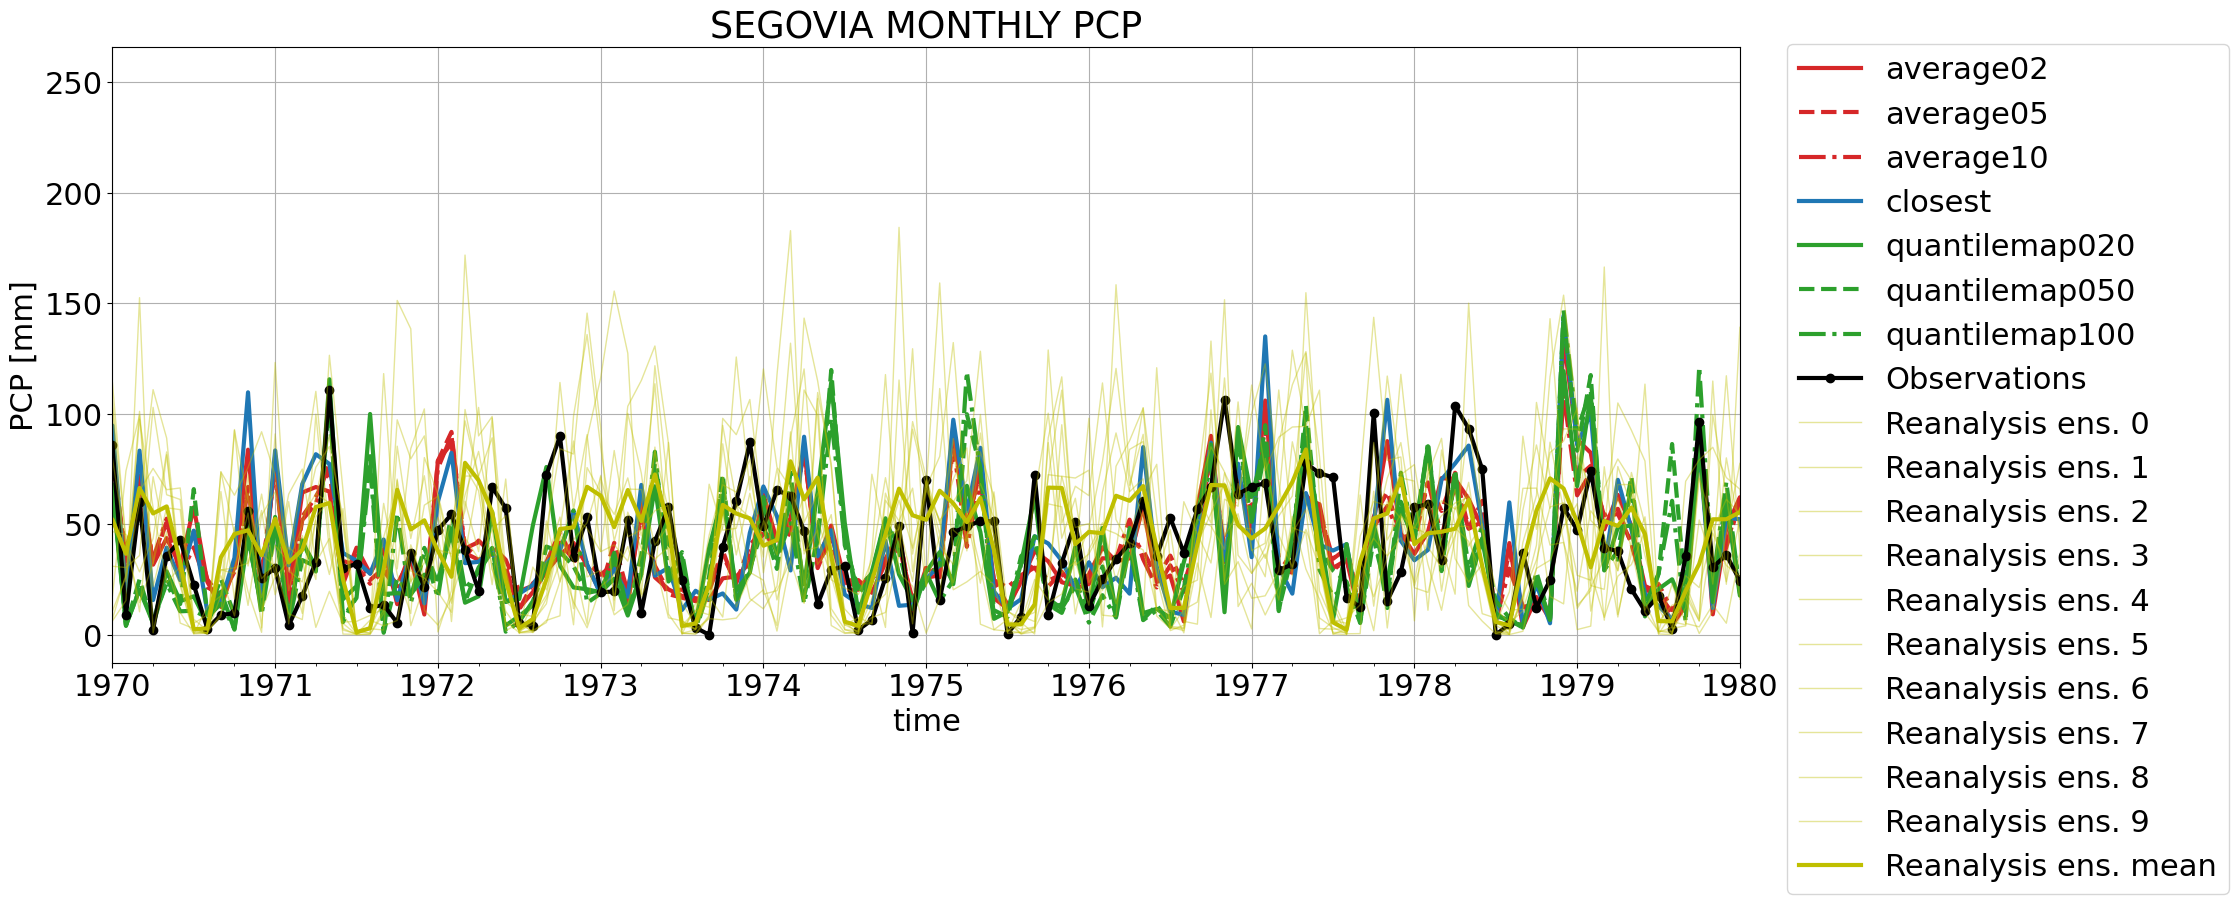

In [15]:
fig, ax = rskill_1m.plotseries(start=datetime.datetime(1970, 1, 1), end=datetime.datetime(1980, 1, 1))
ax.set_title(station.name.upper() + " MONTHLY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.show()

## 1.5) Monthly skill table

In [16]:
_, monthly_skill = rskill_1m.skill()

In [17]:
monthly_skill

bias       rmse        r2        std  \
PCP_average02_reconstructions       0.677271  25.512946  0.557739  23.932765   
PCP_average05_reconstructions        0.62958   23.87298  0.601642  22.047024   
PCP_average10_reconstructions       0.645718  23.234544  0.619896  21.111225   
PCP_closest_reconstructions         0.510667  27.458674  0.538809  26.747419   
PCP_quantilemap020_reconstructions -4.311556  30.540479  0.471831  28.866938   
PCP_quantilemap050_reconstructions -3.447407  30.280482  0.492158  29.947512   
PCP_quantilemap100_reconstructions -2.813481  30.541741  0.500936  30.530591   
PCP_0_reanalysis                   -7.458391  43.918308  0.203351  36.601032   
PCP_1_reanalysis                   -4.866656  42.488775  0.178907  35.806354   
PCP_2_reanalysis                   -3.521927  40.436969  0.227176  35.265305   
PCP_3_reanalysis                   -3.483942  41.349553  0.188423  36.454908   
PCP_4_reanalysis                    -5.42219   42.86243  0.174923  35.774709   
PCP_5_reanalysis                   -3.732262  40.542344  0.228467  34.919346   
PCP_6_reanalysis                   -4.215279  41.654376  0.234177  36.223533   
PCP_7_reanalysis                    -5.68865  44.947709  0.127691  37.896635   
PCP_8_reanalysis                   -4.146192   42.09649  0.237992  36.658341   
PCP_9_reanalysis                   -4.732276   43.04774   0.14618  35.840903   
PCP_mean_reanalysis                -4.726776  31.128475  0.316423  22.039883   

                                             bs  
PCP_average02_reconstructions        650.910404  
PCP_average05_reconstructions        569.919196  
PCP_average10_reconstructions        539.844045  
PCP_closest_reconstructions          753.978800  
PCP_quantilemap020_reconstructions   932.720844  
PCP_quantilemap050_reconstructions   916.907615  
PCP_quantilemap100_reconstructions   932.797941  
PCP_0_reanalysis                    1928.817768  
PCP_1_reanalysis                    1805.295996  
PCP_2_reanalysis                    1635.148480  
PCP_3_reanalysis                    1709.785513  
PCP_4_reanalysis                    1837.187936  
PCP_5_reanalysis                    1643.681689  
PCP_6_reanalysis                    1735.087026  
PCP_7_reanalysis                    2020.296542  
PCP_8_reanalysis                    1772.114438  
PCP_9_reanalysis                    1853.107942  
PCP_mean_reanalysis                  968.981977

## 1.6) Monthly Taylor diagram

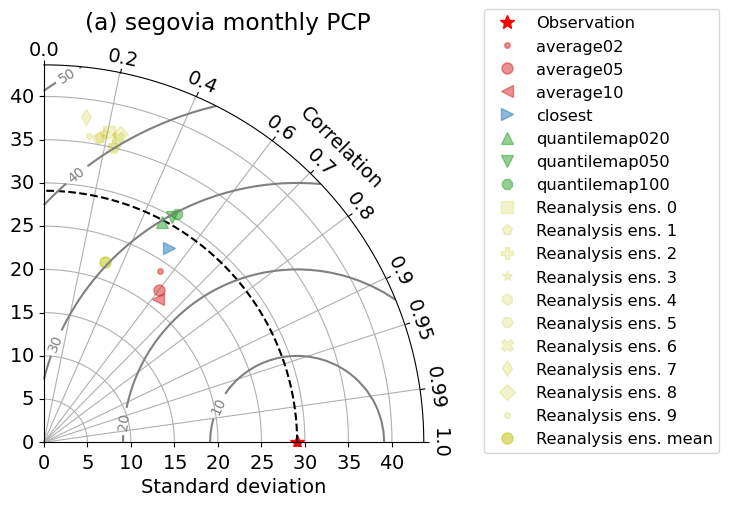

In [18]:
letter = {
    "segovia": "(a) ",
    "navacerrada": "(d) ",
    "colmenar": "(g) ",
    "retiro": "(j) "
}


fig, diag = rskill_1m.taylor()
fig.suptitle(letter[station_to_validate] + station_to_validate + " monthly " + variable_to_validate)

plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/taylor_monthly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png",
    bbox_inches = 'tight'
)


## 1.7) Yearly time series

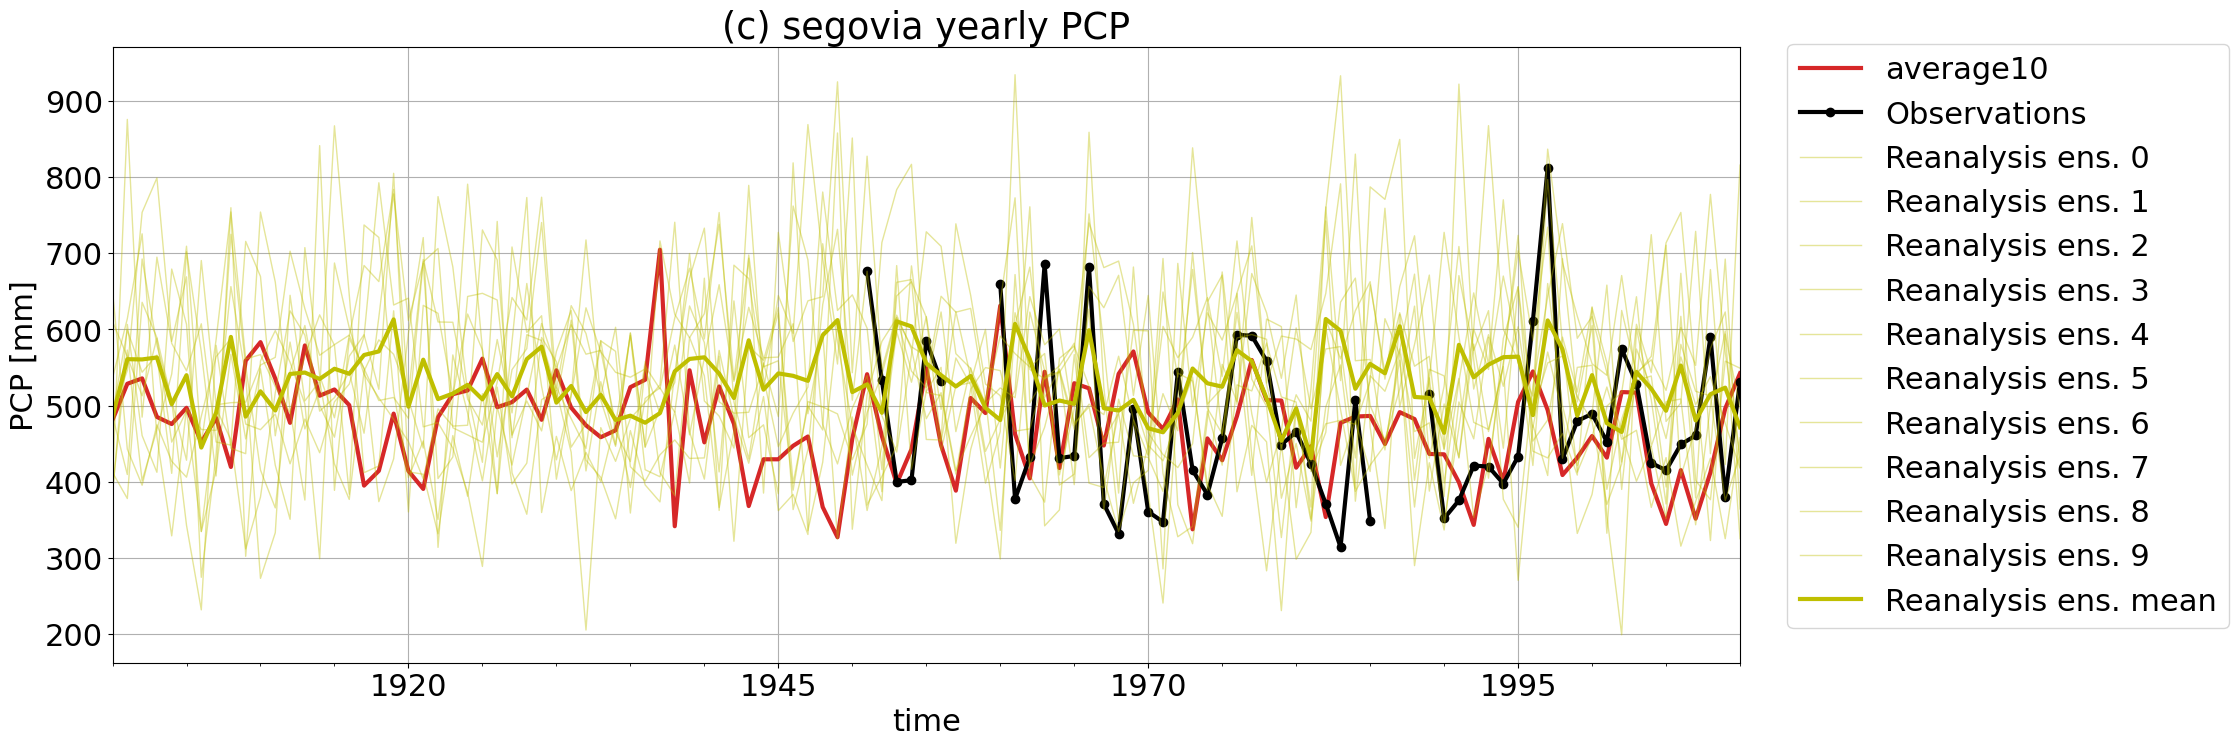

In [19]:
letter = {
    "segovia": "(c) ",
    "navacerrada": "(f) ",
    "colmenar": "(i) ",
    "retiro": "(l) "
}

fig, ax = rskill_1y.plotseries(start=initial_date, end=final_date, methods=[best_method[station_to_validate]])

ax.set_title(letter[station_to_validate] + station.name + " yearly " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])

plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/series_yearly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)

plt.show()

## 1.8) Yearly skill table

In [20]:
_, yearly_skill = rskill_1y.skill()

In [21]:
yearly_skill

bias        rmse        r2  \
PCP_average02_reconstructions       10.466194   96.611584  0.477807   
PCP_average05_reconstructions       10.988665   93.225814  0.494558   
PCP_average10_reconstructions        11.64128   93.159375  0.490511   
PCP_closest_reconstructions          8.018519  103.976732  0.438911   
PCP_quantilemap020_reconstructions -46.596296    129.2489  0.256664   
PCP_quantilemap050_reconstructions -37.040741  122.160709  0.331608   
PCP_quantilemap100_reconstructions -30.151852  129.338897   0.28832   
PCP_0_reanalysis                   -82.853447  171.658606  0.055081   
PCP_1_reanalysis                   -48.416192  170.956197 -0.092742   
PCP_2_reanalysis                   -33.514047  159.159463 -0.066797   
PCP_3_reanalysis                   -29.349498  168.223205   0.02505   
PCP_4_reanalysis                   -56.961754  168.121237  0.090106   
PCP_5_reanalysis                   -43.795839   145.21316  0.247275   
PCP_6_reanalysis                   -54.972464  181.073088 -0.113037   
PCP_7_reanalysis                   -58.975902  146.823707  0.222035   
PCP_8_reanalysis                   -44.564584  153.794357  -0.07789   
PCP_9_reanalysis                    -53.33622  187.245593  -0.25765   
PCP_mean_reanalysis                -50.673995  124.919978  0.009711   

                                           std            bs  
PCP_average02_reconstructions        75.614231   9333.798245  
PCP_average05_reconstructions        68.331807   8691.052370  
PCP_average10_reconstructions        64.476973   8678.669226  
PCP_closest_reconstructions          83.950336  10811.160741  
PCP_quantilemap020_reconstructions   94.778105  16705.278148  
PCP_quantilemap050_reconstructions  101.347292  14923.238889  
PCP_quantilemap100_reconstructions  110.652543  16728.550370  
PCP_0_reanalysis                    108.911865  29466.677089  
PCP_1_reanalysis                    112.768113  29226.021311  
PCP_2_reanalysis                    115.273014  25331.734700  
PCP_3_reanalysis                    138.340477  28299.046834  
PCP_4_reanalysis                    123.609477  28264.750382  
PCP_5_reanalysis                     109.08343  21086.861899  
PCP_6_reanalysis                    116.712645  32787.463352  
PCP_7_reanalysis                    119.812429  21557.200836  
PCP_8_reanalysis                    104.550246  23652.704365  
PCP_9_reanalysis                    119.395942  35060.912188  
PCP_mean_reanalysis                  41.096285  15605.000838

## 1.9) Yearly Taylor diagram

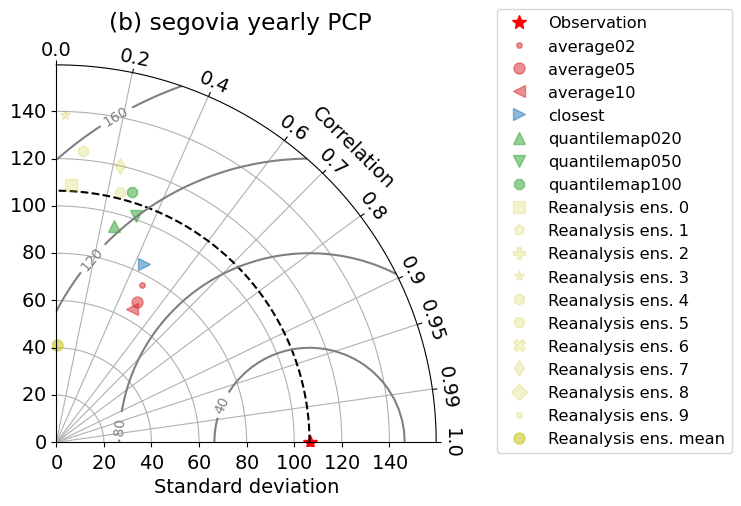

In [22]:
letter = {
    "segovia": "(b) ",
    "navacerrada": "(e) ",
    "colmenar": "(h) ",
    "retiro": "(k) "
}


fig, ax = rskill_1y.taylor()
fig.suptitle(letter[station_to_validate] + station_to_validate + " yearly " + variable_to_validate)

plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/taylor_yearly_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)


# 2) SEASONALITY

## 2.1) Variable Annual Cycle

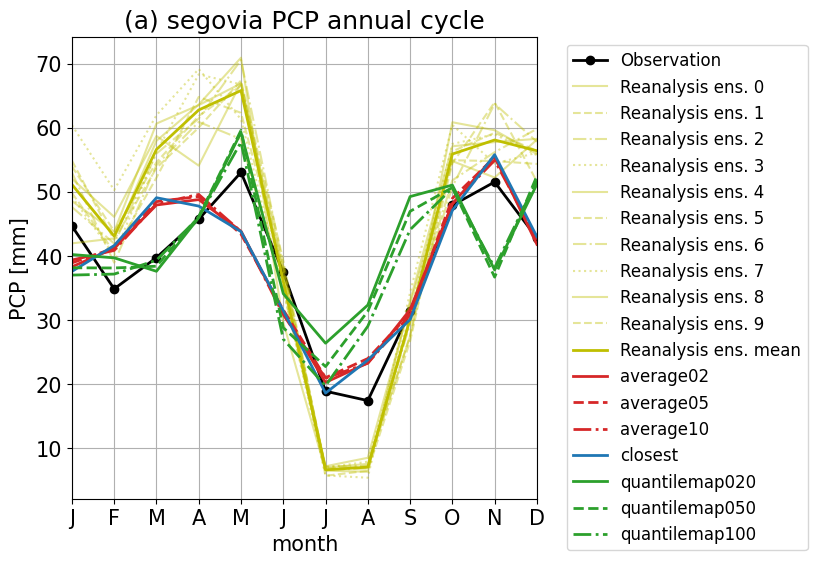

In [23]:
letter = {
    "segovia": "(a) ",
    "navacerrada": "(b) ",
    "colmenar": "(c) ",
    "retiro": "(d) "
}




fig, ax = rskill_1m.annual_cycle(grouping="mean")
ax.set_xlabel("month")
ax.set_title(letter[station_to_validate] + station_to_validate + " " + variable_to_validate + " annual cycle")
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])

plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/cycle_var_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)

## 2.2) Variable Standard Deviation Annual Cycle

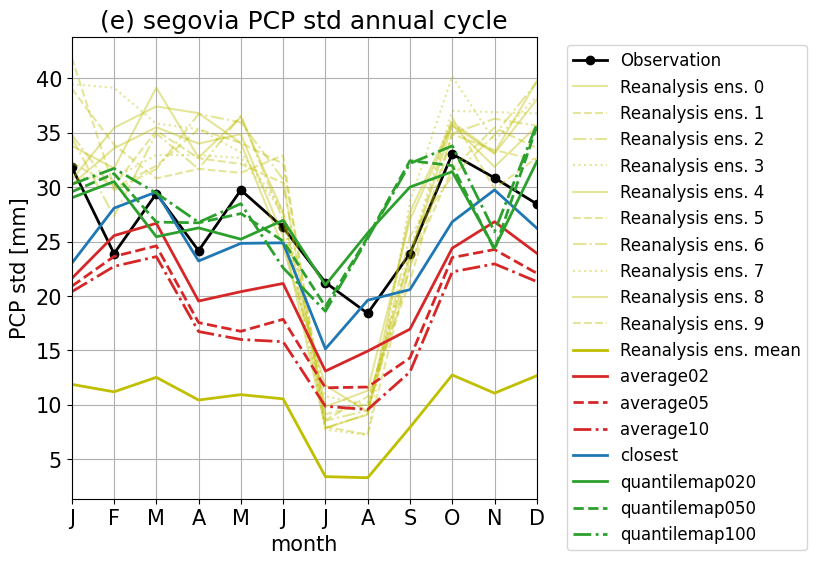

In [24]:
letter = {
    "segovia": "(e) ",
    "navacerrada": "(f) ",
    "colmenar": "(g) ",
    "retiro": "(h) "
}




fig, ax = rskill_1m.annual_cycle(grouping="std")
ax.set_xlabel("month")
ax.set_title(letter[station_to_validate] + station_to_validate + " " + variable_to_validate + " std annual cycle")
ax.set_ylabel(variable_to_validate + " std " + units[variable_to_validate])
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/cycle_std_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)

# 3) DISTRIBUTIONS

## 3.1) Daily Quantile-Quantile Diagram

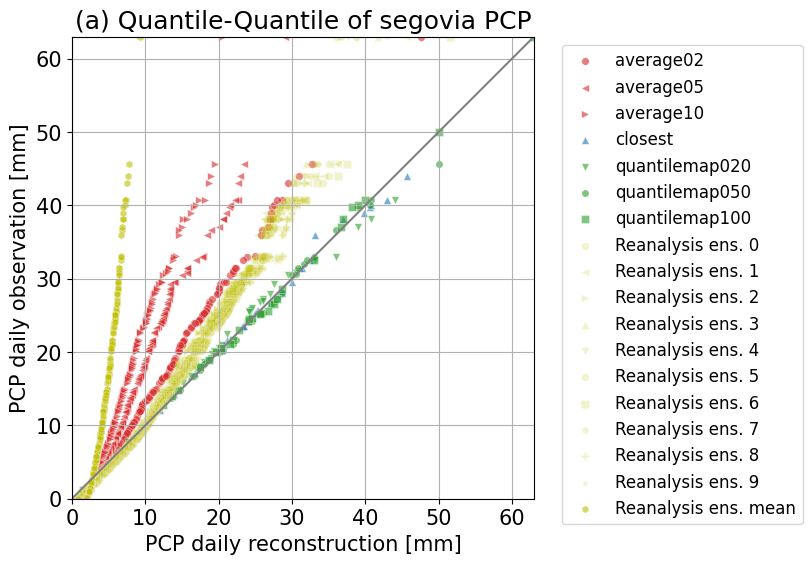

In [25]:
if variable_to_validate == "PCP":
    letter = {
        "segovia": "(a) ",
        "navacerrada": "(b) ",
        "colmenar": "(c) ",
        "retiro": "(d) "
    }
elif variable_to_validate == "TMAX":
    letter = {
        "segovia": "(e) ",
        "navacerrada": "(f) ",
        "colmenar": "(g) ",
        "retiro": "(h) "
    }
elif variable_to_validate == "TMIN":
    letter = {
        "segovia": "(i) ",
        "navacerrada": "(j) ",
        "colmenar": "(k) ",
        "retiro": "(l) "
    }


fig, ax = rskill.qqplot()
ax.set_title(letter[station_to_validate] + "Quantile-Quantile of " + station_to_validate + " " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " daily observation " + units[variable_to_validate])
ax.set_xlabel(variable_to_validate + " daily reconstruction " + units[variable_to_validate])
plt.savefig(
    "/home/alvaro/Documents/Paper_05_RASCAL/graficas/qq_" 
    + variable_to_validate + "_" + station_to_validate
    + ".png"
    , bbox_inches = 'tight'
)

# 4) INDICES

In [26]:
index_name = {
    "fd": "frost days  ($T_{min}$ < 0$^\circ$C)",
    "su": "summer days ($T_{max}$ > 25$^\circ$C)",
    "id": "icing days ($T_{max}$ < 0$^\circ$C)",
    "tr": "tropical nigths ($T_{min}$ > 20$^\circ$C)",
    "r10mm": "R10mm (PCP $\geq$ 10 mm)",
    "r20mm": "R20mm (PCP $\geq$ 20 mm)",
    "rnnmm": "R1mm (PCP $\geq$ 1 mm)",
    "cdd": "consecutive dry days",
    "cwd": "consecutive wet days",
}

In [27]:
station_daily_thr = rascal.indices.get_days_above_threshold(
    station_daily, 
    threshold=threshold, 
    inverse=inverse
)
reconstructions_daily_thr = rascal.indices.get_days_above_threshold(
    reconstructions_daily, 
    threshold=threshold, 
    inverse=inverse
)
reanalysis_daily_thr = rascal.indices.get_days_above_threshold(
    reanalysis_daily, 
    threshold=threshold, 
    inverse=inverse
)


# Daily data 
thrskill = rascal.analysis.RSkill(
    observations=station_daily_thr,
    reconstructions=reconstructions_daily_thr,
    reanalysis=reanalysis_daily_thr
)

# Monthly data
thrskill_1m = thrskill.resample(freq="1m", grouping="sum", hydroyear=hydroyear, skipna=False)

# Yearly data
thrskill_1y = thrskill.resample(freq="1Y", grouping="sum", hydroyear=hydroyear, skipna=False)

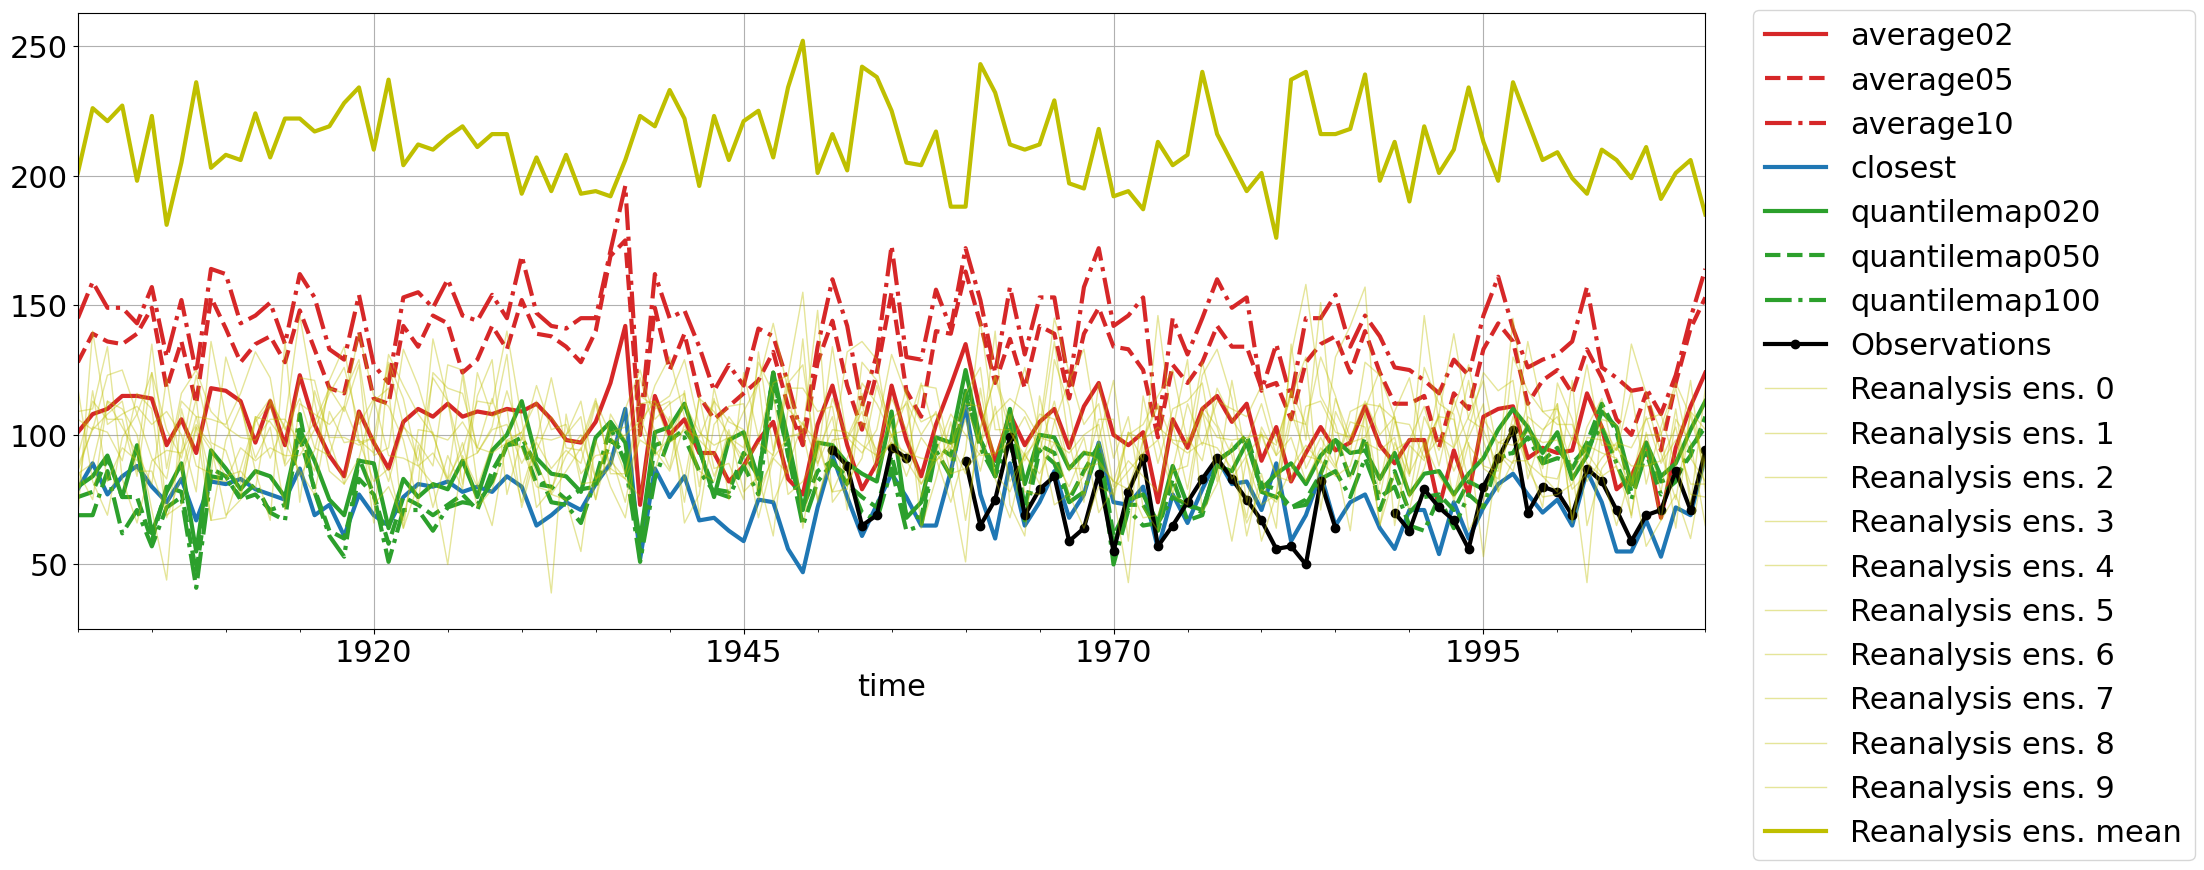

In [28]:
fig, ax = thrskill_1y.plotseries(start=initial_date, end=final_date)

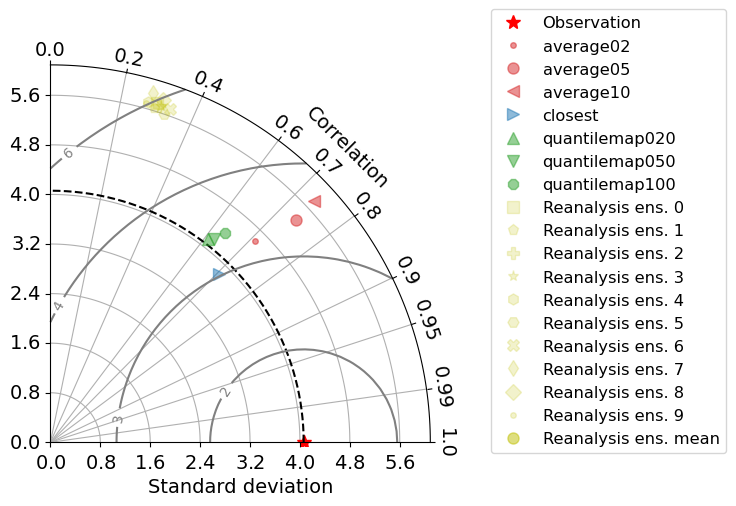

In [29]:
fig, ax = thrskill_1m.taylor()

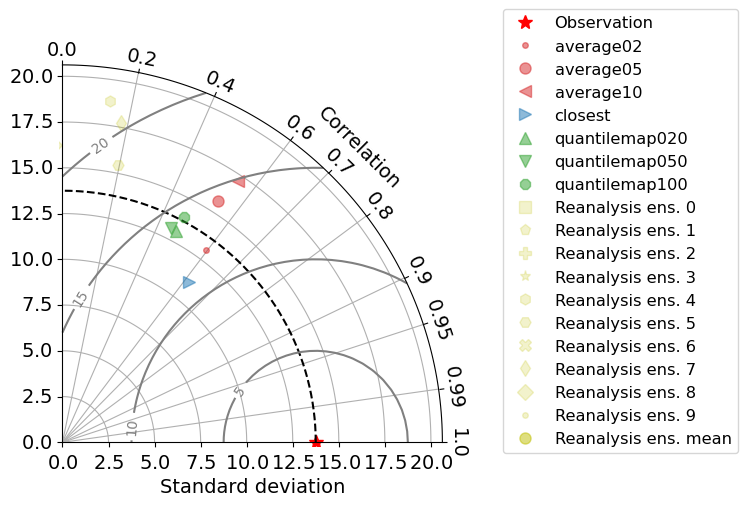

In [30]:
fig, ax = thrskill_1y.taylor()

In [31]:
best_reconstruction_name = "_".join([variable_to_validate, best_method[station_to_validate]])

station_index = rascal.indices.CIndex(station_daily)
reconstruction_index = rascal.indices.CIndex(reconstructions_daily[best_reconstruction_name].to_frame())

In [32]:
if variable_to_validate == "TMIN":
    indices = ["fd", "tr"]
    # indices = ["fd", "tr", "tnx", "tnn", "tx10p", "tn90p", "csdi"]
elif variable_to_validate == "TMAX":
    indices = ["su", "id"]
    # indices = ["su", "id", "txx", "txn", "tx10p", "tn90p", "wsdi"]
elif variable_to_validate == "PCP":
    indices = ["rnnmm", "r10mm", "r20mm", "cdd", "cwd", "r95ptot", "r99ptot"]
    # indices = ["rx1day", "rx5day", "sdii", "r10mm", "r20mm", "rnnmm", "cdd", "r95ptot", "r99tot", "prcptot"]

                     bias      rmse        r2       std
Rnnmm_average10 -5.837302  7.308309  0.643575  5.749147


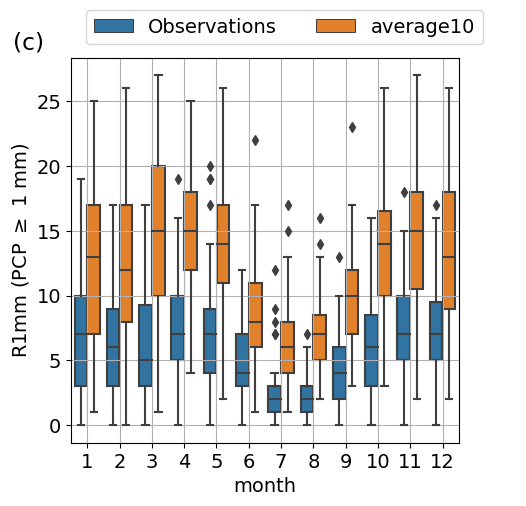

                     bias      rmse        r2       std
R10mm_average10  0.809524  1.412342  0.124142  0.364048


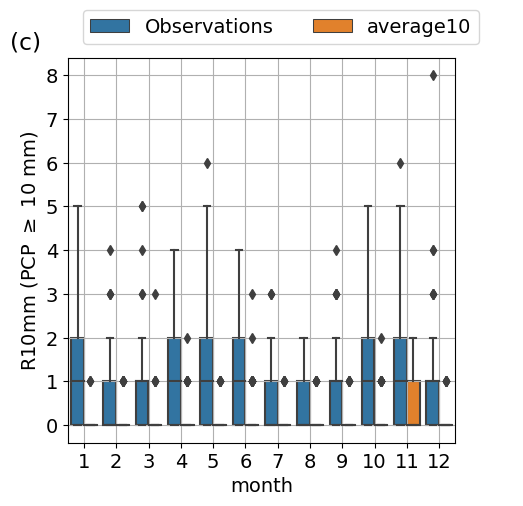

                     bias     rmse        r2       std
R20mm_average10  0.187831  0.52955  0.083926  0.047404


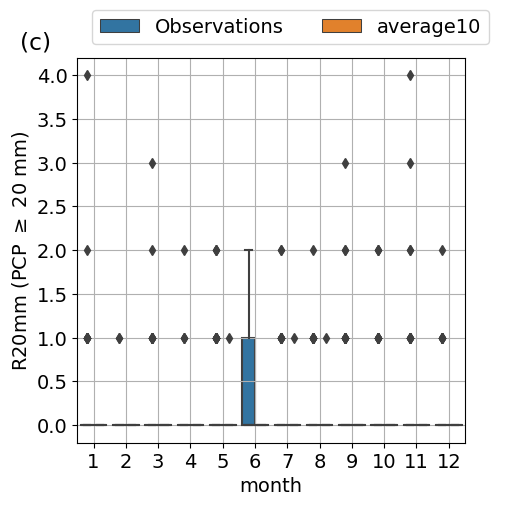

                   bias      rmse        r2       std
CDD_average10  9.017725  15.02332  0.367467  5.892345


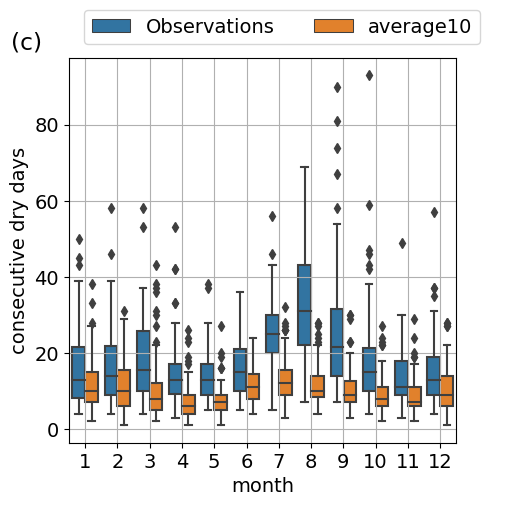

                   bias      rmse        r2       std
CWD_average10 -3.156573  4.798295  0.518034  4.275619


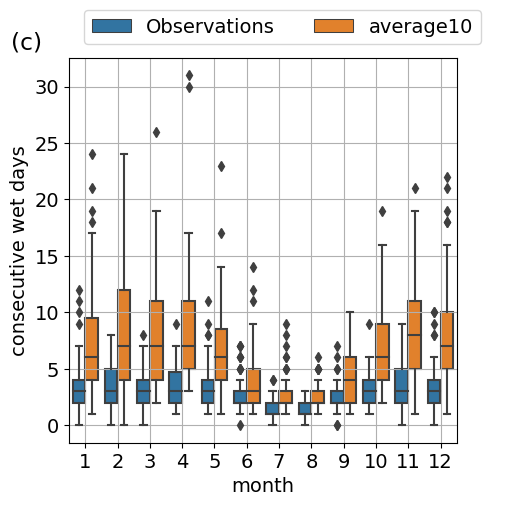

                      bias      rmse        r2       std
R95pTOT_average10 -0.03836  1.836937  0.373527  1.699635


KeyError: 'r95ptot'

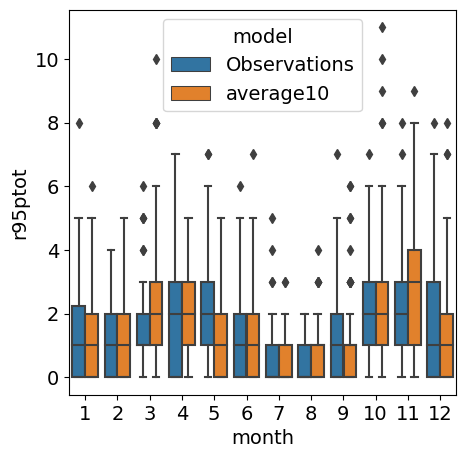

In [33]:

for idx in indices:
    
    if idx == "rnnmm":
        station_idx_series = station_index.rnnmm(threshold=1)
        reconstruction_idx_series = reconstruction_index.rnnmm(threshold=1)
        
    else:     
        get_station_idx_series = getattr(station_index, idx)
        station_idx_series = get_station_idx_series()
    
        get_reconstruction_idx_series = getattr(reconstruction_index, idx)
        reconstruction_idx_series = get_reconstruction_idx_series()
    
    # Monthly Indices
    if idx in ["cdd", "cwd"]:
        station_idx_series_1m = station_idx_series.resample("1m").max()
        reconstruction_idx_series_1m = reconstruction_idx_series.resample("1m").max()
    else:
        station_idx_series_1m = station_idx_series.resample("1m").sum()
        reconstruction_idx_series_1m = reconstruction_idx_series.resample("1m").sum()
    
    _, idx_1m_skill = rascal.analysis.get_skill(
        simulations=reconstruction_idx_series_1m,
        observation=station_idx_series_1m
    )
        
    station_idx_series_1m.columns = [idx]
    station_idx_series_1m["model"] = "Observations"
    
    reconstruction_idx_series_1m.columns = [idx]
    reconstruction_idx_series_1m["model"] = best_method[station_to_validate]
    
    idx_series_1m = pd.concat([station_idx_series_1m, reconstruction_idx_series_1m], axis=0)
    idx_series_1m["month"] = idx_series_1m.index.month
    idx_series_1m.index.name = "time"
    idx_series_1m = idx_series_1m.dropna() 
    idx_series_1m = idx_series_1m.reset_index()

    
    # Yearly Indices
    if idx in ["cdd", "cwd"]:
        station_idx_series_1y = station_idx_series.resample("1Y").max()
        reconstruction_idx_series_1y = reconstruction_idx_series.resample("1Y").max()
    else:
        station_idx_series_1y = station_idx_series.resample("1Y").sum()
        reconstruction_idx_series_1y = reconstruction_idx_series.resample("1Y").sum()
    
    _, idx_1y_skill = rascal.analysis.get_skill(
        simulations=reconstruction_idx_series_1y,
        observation=station_idx_series_1y
    )
    
    print(idx_1m_skill)

    station_idx_series_1y.columns = [idx]
    station_idx_series_1y["model"] = "observations"
    
    reconstruction_idx_series_1y.columns = [idx]
    reconstruction_idx_series_1y["model"] = best_method[station_to_validate]
    
    idx_series_1y = pd.concat([station_idx_series_1y, reconstruction_idx_series_1y], axis=0)
    idx_series_1y.index.name = "time"

    idx_series_1y = idx_series_1y.reset_index()
    

    # Plot series and seasonal cycle
    # fig = plt.figure(figsize=(16, 5))
    # gs = fig.add_gridspec(1, 3)
    
    fig = plt.figure(figsize=(5, 5))
    ax2=fig.subplots()

    # ax1 = fig.add_subplot(gs[0, :-1])
    # ax2 = fig.add_subplot(gs[0, -1])
    
    # if idx in ["tnx", "txn", "cwd", "cdd"]:
    #    sns.lineplot(data=idx_series_1y.dropna(), x="time", y=idx, ax=ax1, hue="model", marker='o')
    #    legend_title = 'R²=' + str(round(idx_1m_skill["r2"].values[0],2))
    #else:
    #    sns.lineplot(data=idx_series_1y, x="time", y=idx, ax=ax1, hue="model", marker='o')
    #    legend_title = 'R²=' + str(round(idx_1m_skill["r2"].values[0],2))
        
    sns.boxplot(data=idx_series_1m, x="month", y=idx, ax=ax2, hue="model")
    
    #ax1.set_ylabel(index_name[idx])
    ax2.set_ylabel(index_name[idx])    

    #ax1.legend().set_title(legend_title)
    ax2.legend(bbox_to_anchor=[0.55, 1.15], loc="upper center", ncol=2)
    
    #ax1.set_xlim(datetime.datetime(1946, 1, 1), datetime.datetime(2011, 1, 1))
    
    #ax1.grid()
    ax2.grid()
    ax2.set_title("(c)                                                                ")
    #fig.subplots_adjust(wspace=0.4)

    plt.show()
